# Code for data Generation step-by-step

In [1]:
import sys

### Installing required Libraries

In [2]:
!{sys.executable} -m pip install numpy hcipy matplotlib h5py tqdm scikit-image 

### Importing required Libraries and function

In [3]:
import sys
import numpy as np
import h5py
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor
from math import pi
from hcipy import imshow_field,make_pupil_grid, make_circular_aperture, Wavefront, Cn_squared_from_fried_parameter, make_focal_grid,Field,read_fits,NoiselessDetector,Detector,make_elliptical_aperture,make_hexagonal_aperture, make_hexagonal_segmented_aperture,make_obstructed_circular_aperture,FraunhoferPropagator,make_fourier_transform
from hcipy.atmosphere import InfiniteAtmosphericLayer,MultiLayerAtmosphere,FresnelPropagator
from skimage.transform import resize
from hcipy.optics import NoisyDetector
from hcipy.field import make_focal_grid_from_pupil_grid
import matplotlib.pyplot as plt
import glob
import imageio.v2 as imageio
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift


## Initialize Parameters

In [4]:
D=1                                             # Diameter of telescope aperture [m]#
pixscale_wanted = 2e-2                                  # [m/pix] pupil min sampling
λmin=550.0e-9                                           # min and max observing wavelengths [m]
λmax=550.0e-9
nframes = 1                                             # Number of frames
exposure_time=1                                       # exposure time for each frame
mag1 = 4
z = 17/360.0*2*pi                                       # observation: angular distance from zenith [radians]
elevation = 2400                                        # observation: elevation
location = "N/A"                                        # location of wind profile
month = "N/A"                                           # month the wind profile was observed
coefficients="0"                                        # 16 values used as coefficients (comma columns, semi-color rows)
nlayers = 4                                             # number of atmospheric layers
Dz = 30e3                                               # propagation distance/elevation highest layer [m]
layer_heights = [0.0]                                   # Heights of each wind vector
set_heights = 0                                         # flag to determine if user set custom height
object_distance = 35786e3                               # [m] - closest distance to object
num_zernikes = 10                                       # Number of Zernike Co-Efficients
true_image = "./data/sat_template1.fits"
wind_file = " "                                         # TEMP: Load elevation and wind profile
repeats = 1                                             # How many times to repeat this process
thread_id = 1                                           # For multiple threads
save_path = "dataset/"                                  # Where files will be stored
focal_length = 10  # Focal length of telescope in meters
winds = np.array([[0.0, 3.0], [10.0, 80.0], [12.0, 25.0], [23.0, 67.0]]) ## (m/s, deg) 0deg = East, increases
winds_dim = 2
r0 = 0.17
L0 = 15.0
wind_file_index = 0
wind_file_array = []
fits_val = False
noise = False

In [7]:
layer_heights_l= np.array([2400,12400,22400,32400])

In [8]:
def pupil_support_size(D, pixsize):
    """
    Get the next power of 2 larger than 2 * D/pixsize.

    """
    return 2 ** int(np.ceil(np.log2(2 * D / pixsize)))


## *Makes a new Grid, meant for descretisation of a pupil-plane wavefront.
### This grid is symmetric around the origin, and therefore has no point exactly on the origin for an even number of pixels.
### make_pupil_grid(dims, diameter=1) https://docs.hcipy.org/0.3.1/api/hcipy.field.make_pupil_grid.html

## *Making aperture for different kinds of apertures
### Example for circular aperture - circular_aperture(diameter, center=None)
### https://docs.hcipy.org/dev/api/hcipy.aperture.circular_aperture.html#hcipy.aperture.circular_aperture

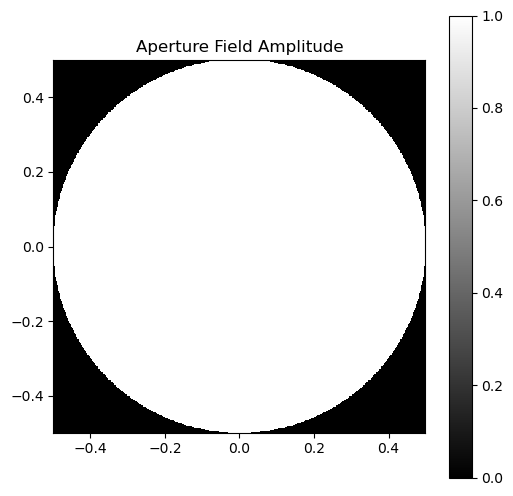

In [23]:
# dimensions of the frame generated
N = pupil_support_size(D, pixscale_wanted)*4

# Makes a new Grid, meant for descretisation of a pupil-plane wavefront.
# This grid is symmetric around the origin, and therefore has no point exactly on the origin for an even number of pixels.
# make_pupil_grid(dims, diameter=1) https://docs.hcipy.org/0.3.1/api/hcipy.field.make_pupil_grid.html
pupil_grid = make_pupil_grid(N, D)

# Make a grid for a focal plane. https://docs.hcipy.org/dev/api/hcipy.field.make_focal_grid.html#make-focal-grid
# make_focal_grid(q, num_airy, spatial_resolution=None, pupil_diameter=None, focal_length=None, f_number=None, reference_wavelength=None)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, q=2, num_airy=128)

# Making aperture for different kinds of apertures
# Example for circular aperture - circular_aperture(diameter, center=None)
# https://docs.hcipy.org/dev/api/hcipy.aperture.circular_aperture.html#hcipy.aperture.circular_aperture
aperture = make_circular_aperture(D)(pupil_grid)
# Visualize the amplitude of the aperture
plt.figure(figsize=(6, 6))
imshow_field(aperture,  cmap='gray')
plt.colorbar()
plt.title("Aperture Field Amplitude")
plt.show()




### Step 1: Making a wavefront which represents the state of light to be propagated through the optical system
### Example - Wavefront(electric_field, wavelength=1, input_stokes_vector=None)
### https://docs.hcipy.org/dev/api/hcipy.optics.Wavefront.html#hcipy.optics.Wavefront

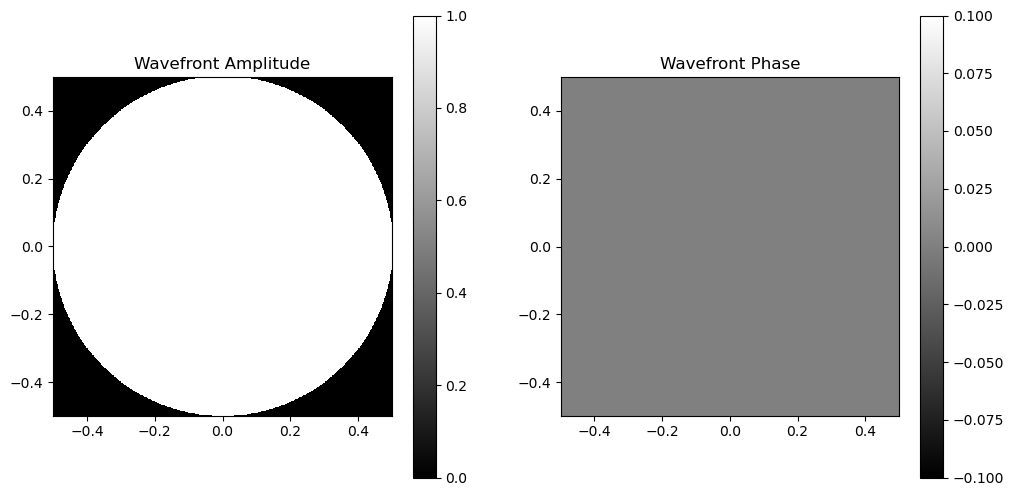

In [85]:

wavefront = Wavefront(Field(aperture, pupil_grid), λmin)

amplitude = wavefront.amplitude
phase = wavefront.phase

# Combined amplitude and phase visualization
plt.figure(figsize=(12, 6))

# Amplitude subplot
plt.subplot(1, 2, 1)
imshow_field(amplitude, wavefront.grid,  cmap='gray')
plt.colorbar()
plt.title("Wavefront Amplitude")

# Phase subplot
plt.subplot(1, 2, 2)
imshow_field(phase, wavefront.grid, cmap='gray')
plt.colorbar()
plt.title("Wavefront Phase")
plt.show()

### Cn_squared_from_fried_parameter https://docs.hcipy.org/dev/api/hcipy.atmosphere.Cn_squared_from_fried_parameter.html
### Returns The integrated Cn^2 value for the atmosphere.

In [86]:

cn2 = Cn_squared_from_fried_parameter(r0, λmin)

# Creating time steps based on number of frames and exposure time
timestamps = np.arange(nframes) * exposure_time


## Step 2: Generate atmosphere layers

In [13]:

layers = []
for height, (speed, direction) in zip(layer_heights_l, winds):

    # Calculating Wind velocities by wind speed and direction
    vx = speed * np.cos(np.radians(direction))
    vy = speed * np.sin(np.radians(direction))

    #An atmospheric layer that can be infinitely extended in any direction. https://docs.hcipy.org/dev/api/hcipy.atmosphere.InfiniteAtmosphericLayer.html
    #InfiniteAtmosphericLayer(input_grid, Cn_squared, L0=inf, velocity=0, height=0, stencil_length=2, use_interpolation=True, seed=None)
    layer = InfiniteAtmosphericLayer(pupil_grid, cn2, L0, velocity=(vx, vy), height=height)
    layers.append(layer)


## A multi-layer atmospheric model. https://docs.hcipy.org/dev/api/hcipy.atmosphere.MultiLayerAtmosphere.html
### MultiLayerAtmosphere(layers, scintillation=False, scintilation=True)

In [14]:
atmosphere = MultiLayerAtmosphere(layers, scintillation=True)

## Defining Detector
### A detector class that has some basic noise properties.
### https://docs.hcipy.org/0.5.1/api/hcipy.optics.NoisyDetector.html
### NoisyDetector(detector_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True, subsampling=1)


In [15]:
detect = NoisyDetector(
            detector_grid=pupil_grid,
            dark_current_rate = 0,
            flat_field =0,
            include_photon_noise=True,
            read_noise=False
        )

## Reading the fits file by read_fits function
### read_fits(filename, extension=0) it returns - ndarray

In [16]:
object_image = read_fits(true_image)
print("object_image shape", object_image.shape)
# object_image = object_image / np.max(object_image)


object_image shape (512, 512)


## Step 3: Evolve all atmospheric layers to a time t.
## https://docs.hcipy.org/0.5.1/api/hcipy.atmosphere.MultiLayerAtmosphere.html#hcipy.atmosphere.MultiLayerAtmosphere.evolve_until

In [48]:
atmosphere.evolve_until(timestamps[0])




## Step 4: Propagate the wavefront forward through the optical element.
# https://docs.hcipy.org/0.5.1/api/hcipy.atmosphere.MultiLayerAtmosphere.html#hcipy.atmosphere.MultiLayerAtmosphere.evolve_until

In [49]:
wavefront_tmp = atmosphere(wavefront)

### Combined amplitude and phase visualization

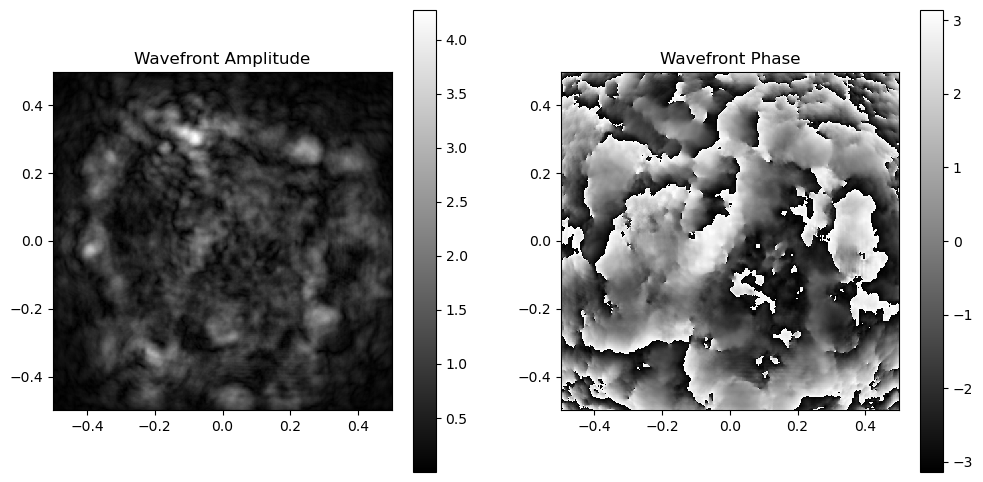

In [50]:
amplitude = wavefront_tmp.amplitude
phase = wavefront_tmp.phase
        

plt.figure(figsize=(12, 6))
# Amplitude subplot
plt.subplot(1, 2, 1)
imshow_field(amplitude, wavefront_tmp.grid,  cmap='gray')
plt.colorbar()
plt.title("Wavefront Amplitude")

# Phase subplot
plt.subplot(1, 2, 2)
imshow_field(phase, wavefront_tmp.grid, cmap='gray')
plt.colorbar()
plt.title("Wavefront Phase")
plt.show()

## Step 5: Passing throught the aperture

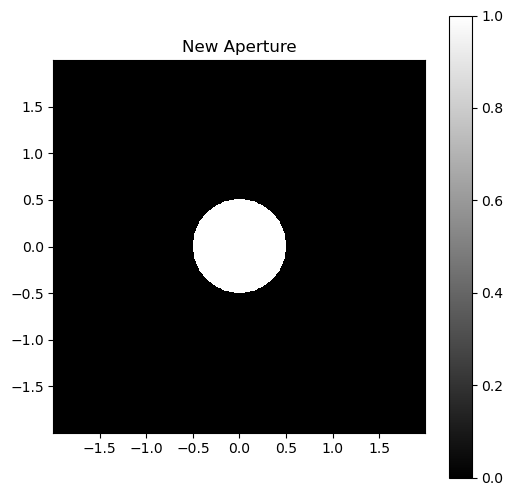

In [51]:
new_pupil_grid = make_pupil_grid(N, D*4)
    
new_aperture = make_circular_aperture(D)(new_pupil_grid)
# Visualize the amplitude of the aperture
plt.figure(figsize=(6, 6))
imshow_field(new_aperture,  cmap='gray')
plt.colorbar()
plt.title("New Aperture")
plt.show()

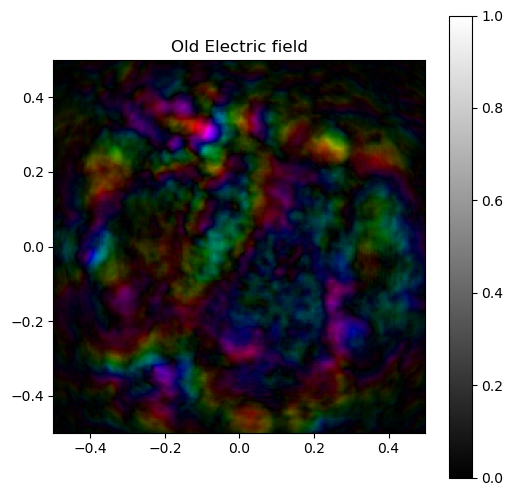

In [53]:
plt.figure(figsize=(6, 6))
imshow_field(wavefront_tmp.electric_field,  cmap='gray')
plt.colorbar()
plt.title("Old Electric field")
plt.show()

## Step 6: Passing through the aperture

In [56]:
wavefront_tmp.electric_field = wavefront_tmp.electric_field *new_aperture

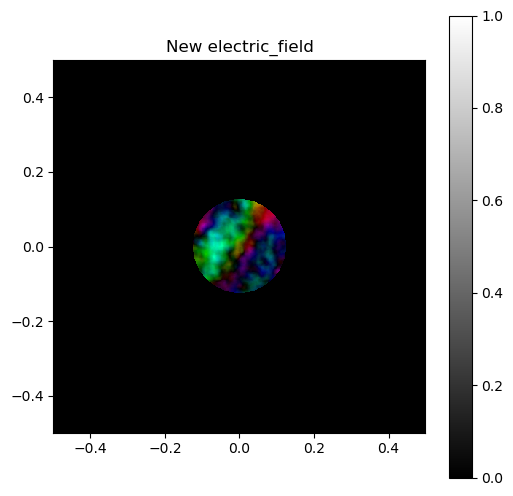

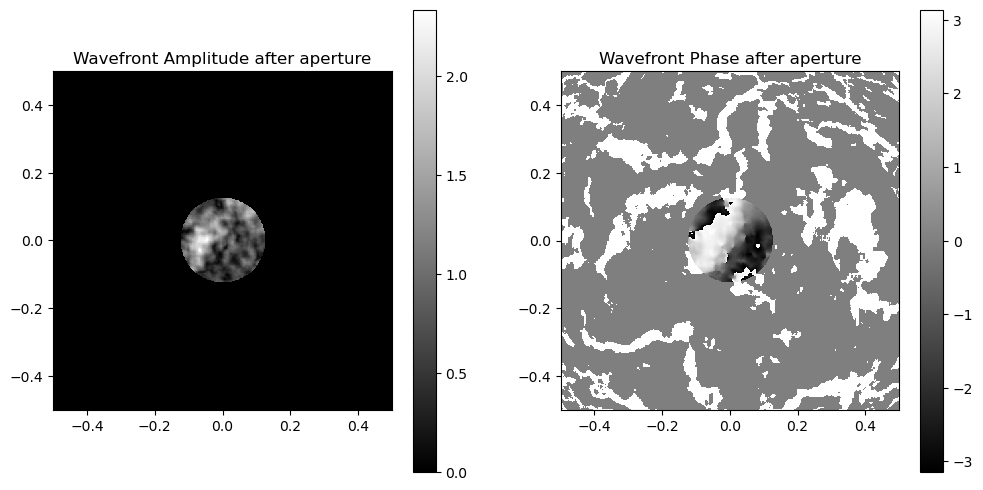

In [57]:


amplitude = wavefront_tmp.amplitude
phase = wavefront_tmp.phase

plt.figure(figsize=(6, 6))
imshow_field(wavefront_tmp.electric_field,  cmap='gray')
plt.colorbar()
plt.title("New electric_field after aperture")
plt.show()
# Combined amplitude and phase visualization
plt.figure(figsize=(12, 6))
    # Amplitude subplot
plt.subplot(1, 2, 1)
imshow_field(amplitude, wavefront_tmp.grid,  cmap='gray')
plt.colorbar()
plt.title("Wavefront Amplitude after aperture")
    # Phase subplot
plt.subplot(1, 2, 2)
imshow_field(phase, wavefront_tmp.grid, cmap='gray')
plt.colorbar()
plt.title("Wavefront Phase after aperture")
plt.show()

## Step 7: Calculate the PSF intensity and normalize

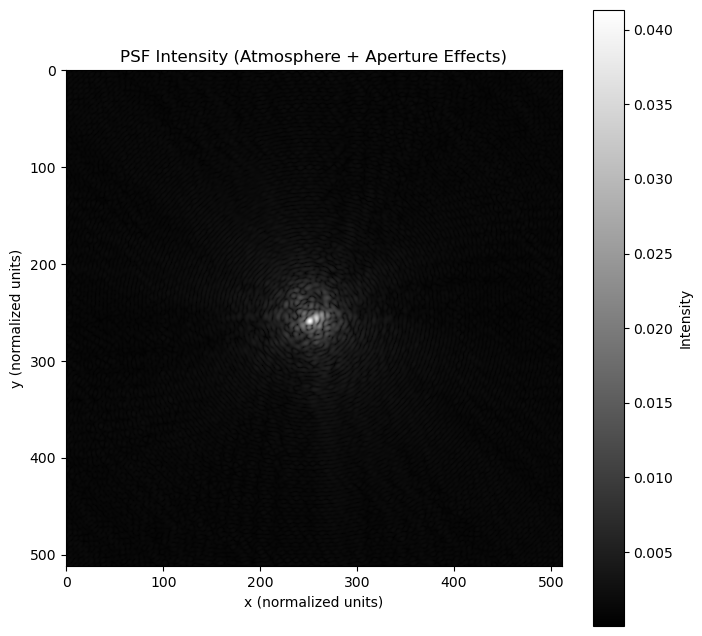

In [78]:
psf_intensity = fftshift(fft2(wavefront_tmp.electric_field.reshape(object_image.shape[0], object_image.shape[0])))
psf = np.abs(psf_intensity)
psf /= np.sum(psf)  # Normalize PSF to have a total sum of 1

# Display the PSF
plt.figure(figsize=(8, 8))
plt.imshow(np.sqrt(psf),  cmap='gray')
plt.colorbar(label="Intensity")
plt.title("PSF Intensity (Atmosphere + Aperture Effects)")
plt.xlabel("x (normalized units)")
plt.ylabel("y (normalized units)")
plt.show()

## Step 8: Fourier Transform the object image

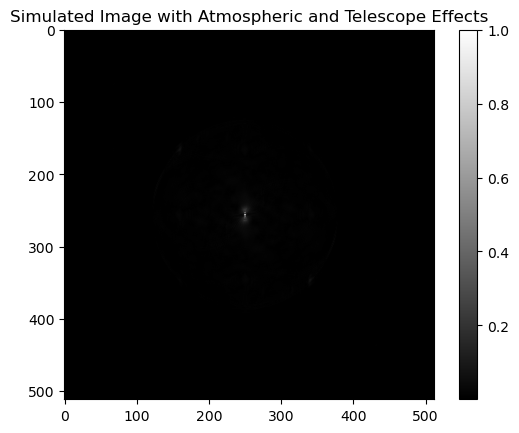

In [89]:
image_fft = fft2(object_image)
# Step 8: Convolve the object's Fourier spectrum with the PSF by multiplication
# psf_fft = psf.reshape(image_fft.shape)
convolved_fft = image_fft * psf
convolved_image = np.abs(ifft2((convolved_fft)))
convolved_image /= convolved_image.max()

# Display the final simulated image
plt.figure()
plt.imshow(convolved_image, cmap='gray')
plt.colorbar()
plt.title("Simulated Image with Atmospheric and Telescope Effects")
plt.show()

## Step 9:Reading out the Wavefront using the detector
### https://docs.hcipy.org/0.3.0/api/hcipy.optics.Detector.html#hcipy.optics.Detector.integrate
### Integrate the detector with the convolved image
### wavefront_convolved = Wavefront(Field(convolved_image.flatten(), focal_grid), wavelength=λmin)

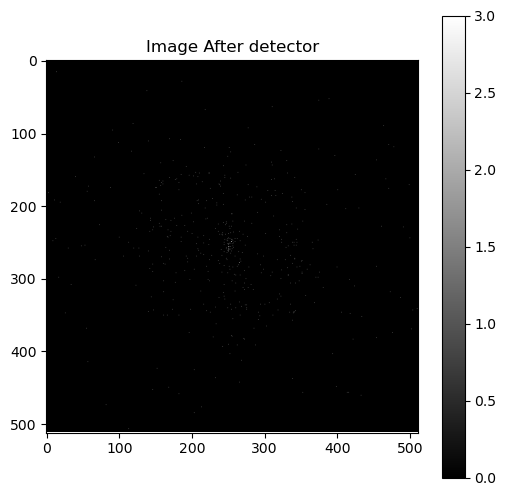

In [91]:
# Convert the intensity image to a Field for the detector
intensity_field = Field(convolved_image.ravel(), pupil_grid)

detect.integrate(intensity_field, exposure_time)
# Read out the final image
detected_image = detect.read_out().shaped

# detected_image = detect(intensity_field, exposure_time).shaped

plt.figure(figsize=(6, 6))
plt.imshow(detected_image, cmap='gray')
plt.colorbar()
plt.title("Image After detector")
plt.show()

# Code for generating multiple frames and a gif

In [84]:
nframes = 50  # Adjust number of frames
# Creating time steps based on number of frames and exposure time
timestamps = np.arange(nframes) * exposure_time

data = []
before_detector =[]
wave_images = []
star_images = []



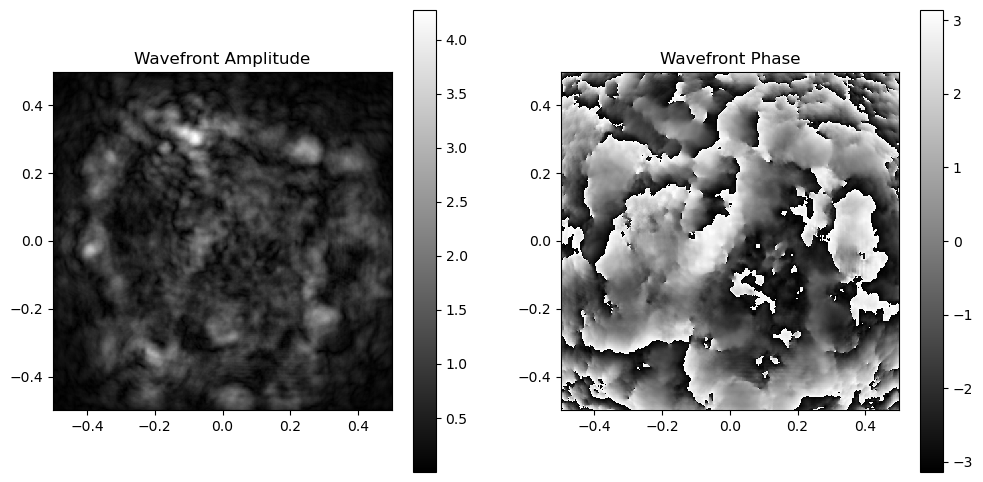

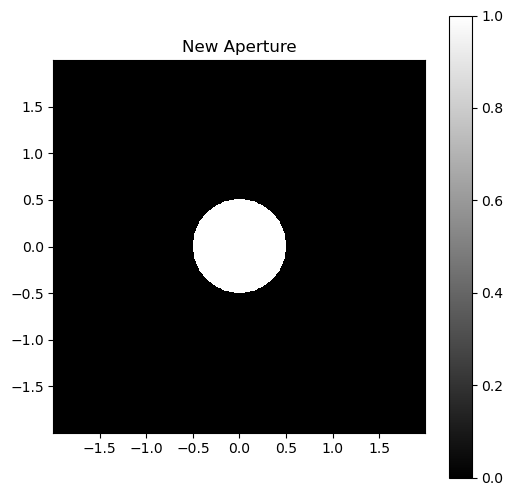

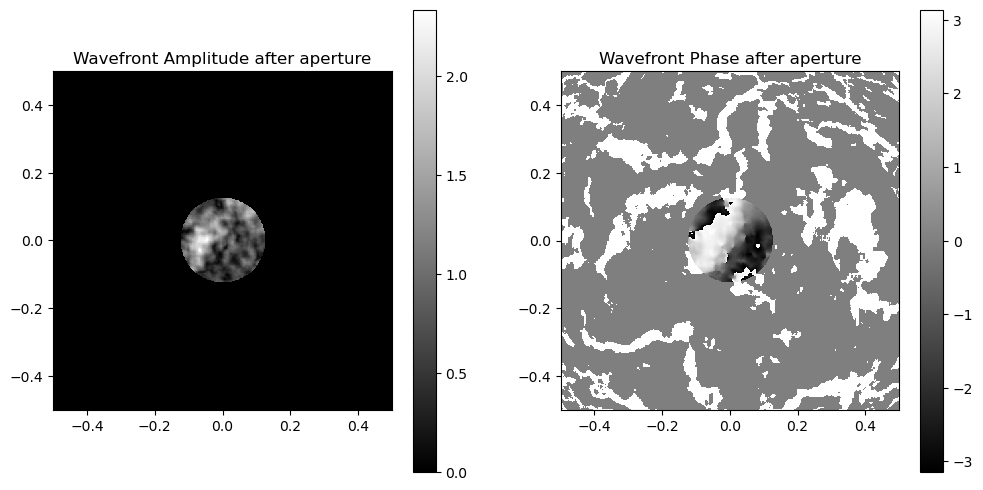

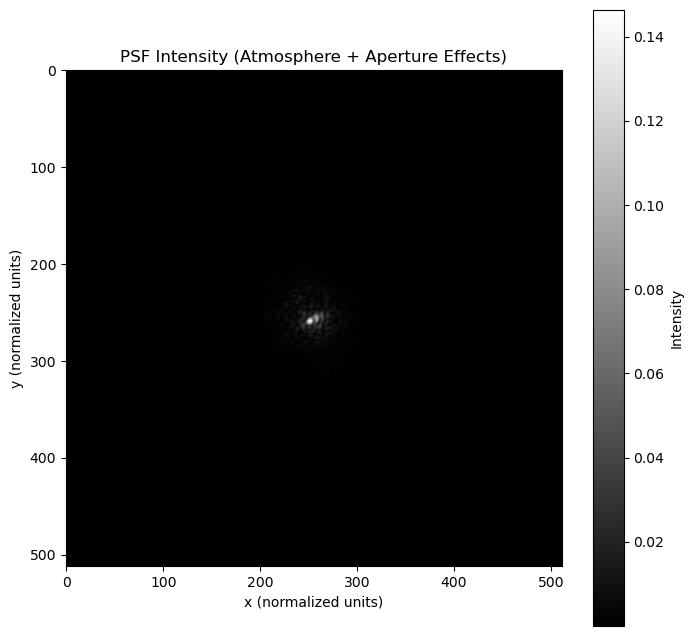

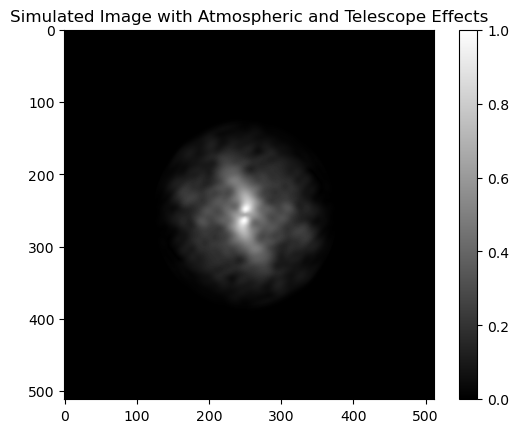

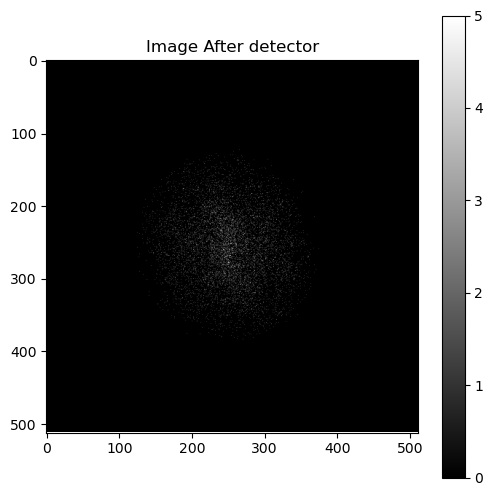

In [28]:
for i, t in enumerate(timestamps):


    # Step 3:Evolve all atmospheric layers to a time t.
    # https://docs.hcipy.org/0.5.1/api/hcipy.atmosphere.MultiLayerAtmosphere.html#hcipy.atmosphere.MultiLayerAtmosphere.evolve_until
    atmosphere.evolve_until(t)

    # Step 4:Propagate the wavefront forward through the optical element.
    # https://docs.hcipy.org/0.5.1/api/hcipy.atmosphere.MultiLayerAtmosphere.html#hcipy.atmosphere.MultiLayerAtmosphere.evolve_until
    wavefront_tmp = atmosphere(wavefront)

    amplitude = np.abs(wavefront_tmp.electric_field)
    phase = np.angle(wavefront_tmp.electric_field)
        
    # Combined amplitude and phase visualization
    plt.figure(figsize=(12, 6))
    # Amplitude subplot
    plt.subplot(1, 2, 1)
    imshow_field(amplitude, wavefront_tmp.grid,  cmap='gray')
    plt.colorbar()
    plt.title("Wavefront Amplitude")

    # Phase subplot
    plt.subplot(1, 2, 2)
    imshow_field(phase, wavefront_tmp.grid, cmap='gray')
    plt.colorbar()
    plt.title("Wavefront Phase")
    plt.show()

    wave_images.append(wavefront_tmp.phase) # Storing Phase for visualization

    # Step 5: Passing throught the aperture
    new_pupil_grid = make_pupil_grid(N, D*4)
    
    new_aperture = make_circular_aperture(D)(new_pupil_grid)
    # Visualize the amplitude of the aperture
    plt.figure(figsize=(6, 6))
    imshow_field(new_aperture,  cmap='gray')
    plt.colorbar()
    plt.title("New Aperture")
    plt.show()

    wavefront_tmp.electric_field = wavefront_tmp.electric_field *new_aperture

    amplitude = np.abs(wavefront_tmp.electric_field)
    phase = np.angle(wavefront_tmp.electric_field)

    # Combined amplitude and phase visualization
    plt.figure(figsize=(12, 6))

    # Amplitude subplot
    plt.subplot(1, 2, 1)
    imshow_field(amplitude, wavefront_tmp.grid,  cmap='gray')
    plt.colorbar()
    plt.title("Wavefront Amplitude after aperture")

    # Phase subplot
    plt.subplot(1, 2, 2)
    imshow_field(phase, wavefront_tmp.grid, cmap='gray')
    plt.colorbar()
    plt.title("Wavefront Phase after aperture")
    plt.show()

    # Storing data without Detector for visualization
    # This computes the intensity of the wavefront, it calculates the power or brightness distribution of the light in the focal plane. .shaped converts it into 2D
    # psf = wavefront_tmp.intensity.shaped
    # Step 6: Calculate the PSF intensity and normalize
    # psf_intensity = wavefront_tmp.intensity.shaped
    psf_intensity = fftshift(fft2(wavefront_tmp.electric_field.reshape(object_image.shape[0], object_image.shape[0])))
    psf = np.abs(psf_intensity)**2
    psf /= np.sum(psf)  # Normalize PSF to have a total sum of 1


    # Display the PSF
    plt.figure(figsize=(8, 8))
    plt.imshow(np.sqrt(psf),  cmap='gray')
    plt.colorbar(label="Intensity")
    plt.title("PSF Intensity (Atmosphere + Aperture Effects)")
    plt.xlabel("x (normalized units)")
    plt.ylabel("y (normalized units)")
    plt.show()
        
    psf1 = np.array(psf)
    data.append(psf1)


    # Step 7: Fourier Transform the object image
    # image_fft = (fft2(object_image))
    image_fft = fft2(object_image)
    # Step 8: Convolve the object's Fourier spectrum with the PSF by multiplication
    # psf_fft = psf.reshape(image_fft.shape)
    convolved_fft = image_fft * psf
    convolved_image = np.abs(ifft2((convolved_fft)))
    convolved_image /= convolved_image.max()

    # Step 9: Display the final simulated image
    plt.figure()
    plt.imshow(convolved_image, cmap='gray')
    plt.colorbar()
    plt.title("Simulated Image with Atmospheric and Telescope Effects")
    plt.show()

    before_detector.append(convolved_image)

    # Convert the intensity image to a Field for the detector
    intensity_field = Field(convolved_image.ravel(), pupil_grid)

    # Reading out the Wavefront using the detector
    # https://docs.hcipy.org/0.3.0/api/hcipy.optics.Detector.html#hcipy.optics.Detector.integrate
    # Integrate the detector with the convolved image
    # wavefront_convolved = Wavefront(Field(convolved_image.flatten(), focal_grid), wavelength=λmin)

    detect.integrate(intensity_field, exposure_time)
    # Read out the final image
    detected_image = detect.read_out().shaped

    # detected_image = detect(intensity_field, exposure_time).shaped

    plt.figure(figsize=(6, 6))
    plt.imshow(detected_image, cmap='gray')
    plt.colorbar()
    plt.title("Image After detector")
    plt.show()
   



    # detected_image = detect(wavefront_convolved, exposure_time).shaped
    star_images.append(detected_image)





In [ ]:
def generate_gif(X, T, process='forward', base_folder='gif_images'):
    X = np.array(X)
    min_val = X.min()
    max_val = X.max()
    X_norm = (X - min_val) / (max_val - min_val)
    for t in range(T):
        frame = X_norm[t].reshape((512, 512, 1))
        cv2.imwrite(os.path.join(base_folder, f'frame_{t}.png'), ((frame * 255) // 1).astype(np.uint8))
    images = [0] * T

    for filename in glob.glob(f"gif_images/*.png"):
        idx = int(filename.split('/')[-1].split('_')[1].split('.')[0])
        if process == 'reverse':
            idx = T - idx - 1
        images[idx] = imageio.imread(filename)

    print(len(images))
    imageio.mimsave(f'gifs/{process}.gif', images)

    for image_file in glob.glob(f"gif_images/*.png"):
        os.remove(image_file)

In [ ]:
# Save images and generate GIFs for each aperture type
generate_gif(data, nframes, process=f'PSF_image')
generate_gif(star_images, nframes, process=f'Star_image')
generate_gif(wave_images, nframes, process=f'Wave_image')
generate_gif(before_detector, nframes, process=f'before_detector_image')
